In [57]:
from datadrivencloud.data import tiffImageDataset
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import xarray as xr
from datadrivencloud.utils import plot_xarray_chip
import torch
from datadrivencloud.modules import CloudModel
import warnings


In [ ]:
checkpoint = '../lightning_logs/version_18/checkpoints/epoch=35-step=23795.ckpt'

model = CloudModel.load_from_checkpoint(checkpoint).cuda().eval()

In [3]:
def model_function(ckpt_path):
    def apply_model(x):
        x = x[None,].cuda()
        y = (model(x) > 0.5).detach().cpu().numpy().astype("uint8")
        return y[0]
    return apply_model

In [4]:
df = pd.read_csv("/driven-data/cloud-cover/train_metadata.csv")

In [5]:
df['TP'] = np.nan
df['FP'] = np.nan
df['TN'] = np.nan
df['FN'] = np.nan

In [6]:
df.head()

,chip_id,location,datetime,cloudpath,TP,FP,TN,FN
0,adwp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwp,NaN,NaN,NaN,NaN
1,adwu,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwu,NaN,NaN,NaN,NaN
2,adwz,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwz,NaN,NaN,NaN,NaN
3,adxp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adxp,NaN,NaN,NaN,NaN
4,aeaj,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/aeaj,NaN,NaN,NaN,NaN


In [7]:
dataloader = torch.utils.data.DataLoader(
    tiffImageDataset(df),
    shuffle=False,
    batch_size=32,
    num_workers=4
)

In [8]:
def confusion_values(pred, y):
    dims = tuple(i+1 for i in range(len(y.shape)-1))
    TP = torch.logical_and(pred, y).sum(dim=dims)
    TN = torch.logical_and(~pred, ~y).sum(dim=dims)
    FP = torch.logical_and(pred, ~y).sum(dim=dims)
    FN = torch.logical_and(~pred, y).sum(dim=dims)  
    return TP, TN, FP, FN

In [9]:
idx = 0
for batch in tqdm(dataloader):
    images, labels = batch
    preds = model(images.cuda())>0.5
    TP, TN, FP, FN = [x.cpu().numpy() for x in confusion_values(preds, labels.cuda().bool())]
    df['TP'].values[idx:idx+images.shape[0]] = TP
    df['TN'].values[idx:idx+images.shape[0]] = TN
    df['FP'].values[idx:idx+images.shape[0]] = FP
    df['FN'].values[idx:idx+images.shape[0]] = FN
    idx += images.shape[0]

100%|██████████| 368/368 [18:10<00:00,  2.96s/it]


In [10]:
df['IoU'] = df.TP / (df.TP + df.FP + df.FN)

In [11]:
df

,chip_id,location,datetime,cloudpath,TP,FP,TN,FN,IoU
0,adwp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwp,95678.0,3085.0,133415.0,29966.0,0.743251
1,adwu,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwu,166411.0,51553.0,43695.0,485.0,0.761784
2,adwz,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwz,262065.0,0.0,0.0,79.0,0.999699
3,adxp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adxp,262144.0,0.0,0.0,0.0,1.000000
4,aeaj,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/aeaj,262144.0,0.0,0.0,0.0,1.000000
...,...,...,...,...,...,...,...,...,...
11743,zxwv,Launceston,2020-09-06T00:08:20Z,az://./train_features/zxwv,158945.0,0.0,0.0,103199.0,0.606327
11744,zxxo,Launceston,2020-09-06T00:08:20Z,az://./train_features/zxxo,29296.0,2081.0,216175.0,14592.0,0.637299
11745,zxym,Launceston,2020-09-06T00:08:20Z,az://./train_features/zxym,260159.0,646.0,522.0,817.0,0.994408
11746,zxza,Launceston,2020-09-06T00:08:20Z,az://./train_features/zxza,251955.0,0.0,0.0,10189.0,0.961132


In [12]:
df.IoU.mean()

0.810293395548517

In [19]:
df[df.IoU>0.1].mean()/(512**2)

TP     0.626408
FP     0.021828
TN     0.307969
FN     0.043795
IoU    0.000003
dtype: float64

<AxesSubplot:>

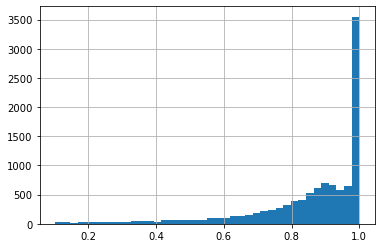

In [15]:
df[df.IoU>0.1].IoU.hist(bins=40)

<AxesSubplot:xlabel='location'>

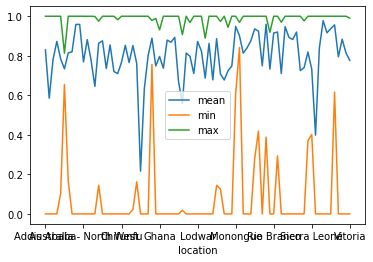

In [10]:
df.groupby(df.location).IoU.agg(['mean','min', 'max']).plot()

In [23]:
df.nsmallest(10, 'IoU')

,chip_id,location,datetime,cloudpath,IoU
120,ahfi,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/ahfi,0.0
172,aisf,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/aisf,0.0
227,akkb,Addis Ababa,2020-09-10T07:57:42Z,az://./train_features/akkb,0.0
253,alfq,Addis Ababa,2020-09-10T07:57:42Z,az://./train_features/alfq,0.0
256,alht,Addis Ababa,2020-09-10T07:57:42Z,az://./train_features/alht,0.0
293,amgj,Addis Ababa,2020-09-10T07:57:42Z,az://./train_features/amgj,0.0
330,ankq,Addis Ababa,2020-09-10T07:57:42Z,az://./train_features/ankq,0.0
407,apiw,Bahir Dar,2020-09-08T08:06:56Z,az://./train_features/apiw,0.0
506,asaq,Bahir Dar,2020-09-08T08:06:56Z,az://./train_features/asaq,0.0
621,auza,Chingola,2020-07-26T08:33:40Z,az://./train_features/auza,0.0


In [20]:
df.to_csv("../lightning_logs/version_18/train_metadata_results.csv")

In [2]:
df = pd.read_csv("../lightning_logs/version_18/train_metadata_results.csv")

FileNotFoundError: [Errno 2] No such file or directory: '../lightning_logs/version_18/train_metadata_results.csv'

In [11]:
dataset = dataloader.dataset

In [63]:
def create_image_figure(indices, dataset):

    xy = np.arange(512)
    band = ['B02', 'B03', 'B04', 'B08', 'cloud_mask']
    n = len(indices)
    fig, axes = plt.subplots(n,4, figsize=(12, 3*n), sharex=True, sharey=True)
    axes = axes.reshape(n,4)

    for i, idx in zip(range(n), indices):
        
        chip_id = dataset.df.iloc[idx].chip_id
        iou = dataset.df.iloc[idx].IoU
        image, label = dataset[idx]
        pred = (model(image[None,].cuda()) > 0.5).detach().cpu().numpy().astype("uint8")[0]
        x = image.numpy()
        y = label.numpy()
        ds_y = xr.DataArray(np.concatenate([x, y], axis=0), 
                          dims=['band', 'x', 'y'], coords=[band, xy, xy], name='images')
        ds_pred = xr.DataArray(np.concatenate([x, pred], axis=0), 
                          dims=['band', 'x', 'y'], coords=[band, xy, xy], name='images')
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', UserWarning)
            plot_xarray_chip(ds_y, ax=axes[i, 0], cloud_contour=True, nodata=-torch.inf, infrared_alpha=False)
            axes[i, 1].contourf(ds_y.sel(band='cloud_mask'), cmap='Blues', levels=[0.5,1], vmin=0, vmax=1)
            axes[i, 1].contour(ds_y.sel(band='cloud_mask'), cmap='Blues', vmin=0, vmax=1, linewidths=.5)
            axes[i, 1].set_aspect(axes[i, 0].get_aspect())
            #axes[i, 1].annotate(chip_id, xy=(0.05, 0.9), xycoords='axes fraction')
            axes[i, 0].set_ylabel(f"{chip_id} : {iou:.4f}")
            plot_xarray_chip(ds_pred, ax=axes[i, 2], cloud_contour=True, nodata=-torch.inf, infrared_alpha=False)
            axes[i, 3].contourf(ds_pred.sel(band='cloud_mask'), cmap='Blues', levels=[0.5,1], vmin=0, vmax=1)
            axes[i, 3].contour(ds_pred.sel(band='cloud_mask'), cmap='Blues', vmin=0, vmax=1, linewidths=.5)
            axes[i, 3].set_aspect(axes[i, 0].get_aspect())
    return fig

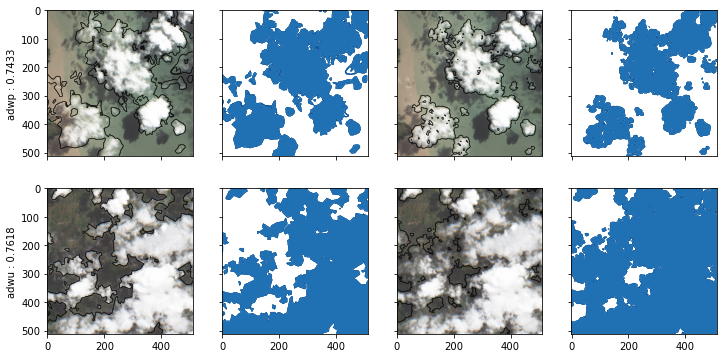

In [64]:
create_image_figure([0,1], dataset)
plt.show()

In [71]:
def n_smallest_after(df, n, skip=0):
    return df.nsmallest(n+skip, 'IoU').iloc[skip:].index

In [72]:
def n_largest_after(df, n, skip=0):
    return df.nlargest(n+skip, 'IoU').iloc[skip:].index

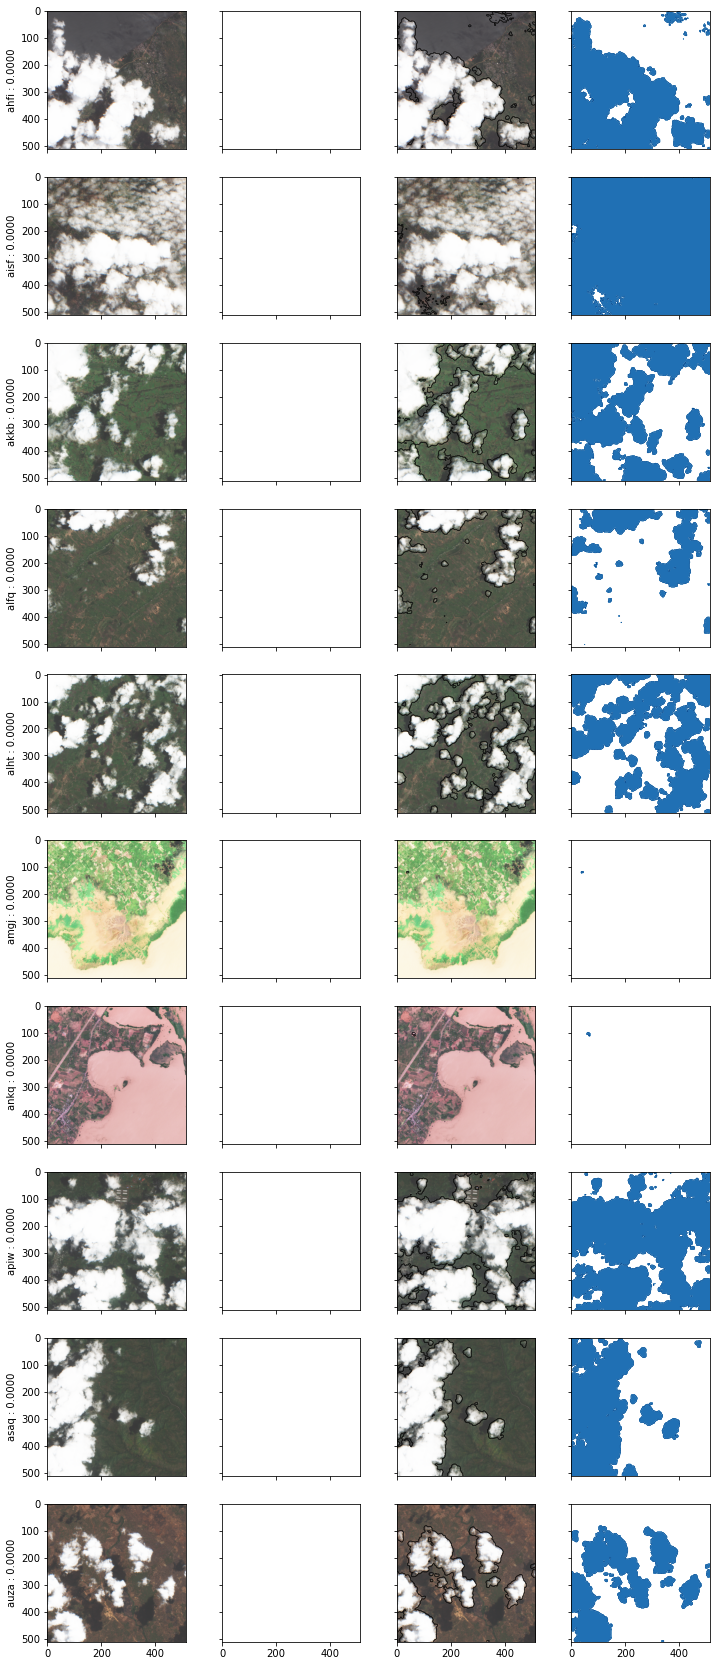

In [68]:
create_image_figure(n_smallest_after(df, 10), dataset)
plt.show()

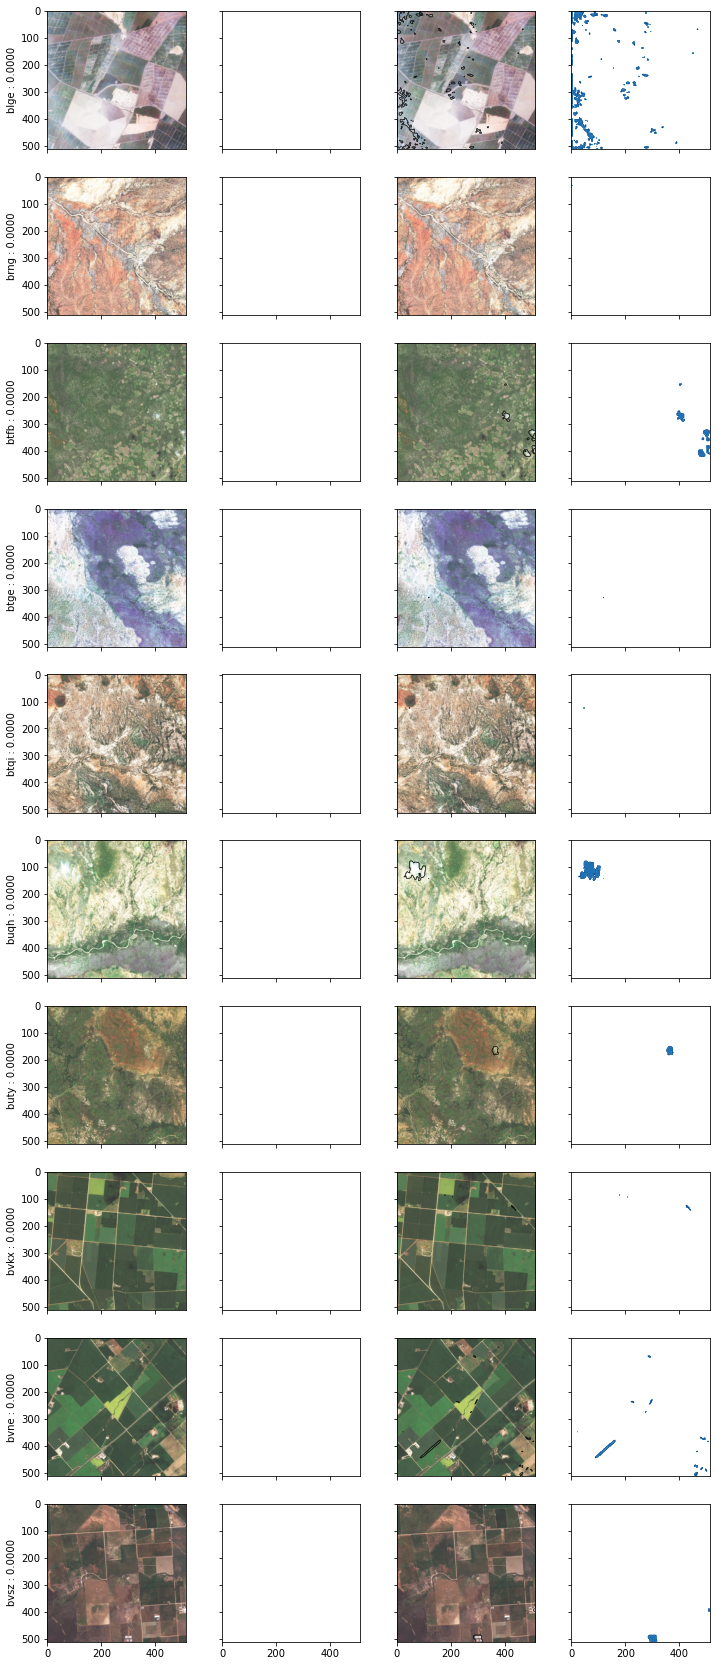

In [70]:
create_image_figure(n_smallest_after(df, 10, skip=20), dataset)
plt.show()

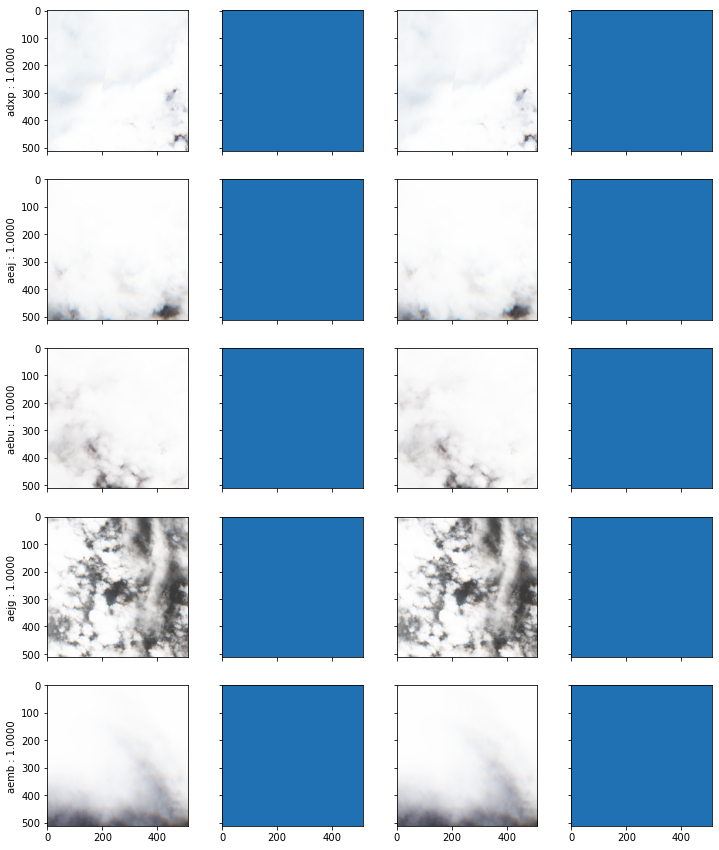

In [78]:
create_image_figure(n_largest_after(df, 5), dataset)
plt.show()

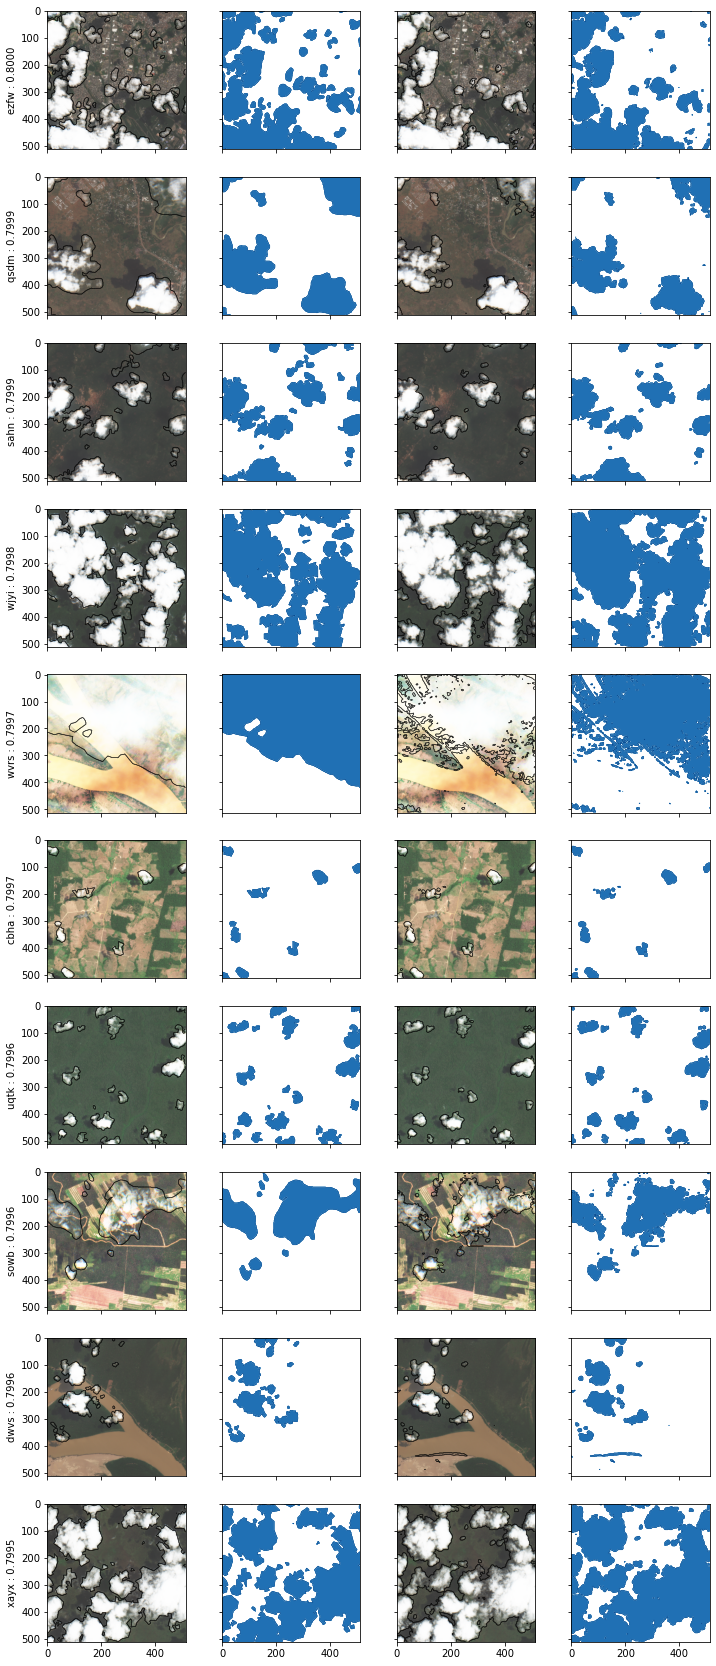

In [79]:
create_image_figure(n_largest_after(df.query('IoU<0.8'), 10, skip=0), dataset)
plt.show()

In [3]:
from datadrivencloud.data import df_location_train_test_split

In [4]:
df_train, df_test = df_location_train_test_split(df, 0.2, 25334)

14 test locations and 67 train locations


<AxesSubplot:xlabel='location'>

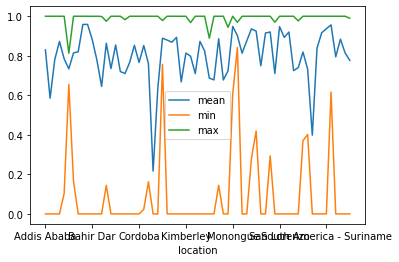

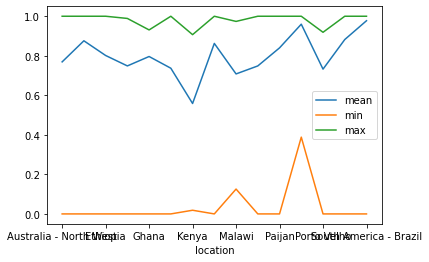

In [5]:
df_train.groupby(df_train.location).IoU.agg(['mean','min', 'max']).plot()
df_test.groupby(df_test.location).IoU.agg(['mean','min', 'max']).plot()


In [6]:
vs = []
for i in range(2000):
    df_train, df_test = df_location_train_test_split(df, 0.2)
    vs += [df_test.IoU.mean()/df_train.IoU.mean()]

14 test locations and 67 train locations
14 test locations and 67 train locations
15 test locations and 66 train locations
16 test locations and 65 train locations
17 test locations and 64 train locations
16 test locations and 65 train locations
13 test locations and 68 train locations
17 test locations and 64 train locations
17 test locations and 64 train locations
14 test locations and 67 train locations
13 test locations and 68 train locations
16 test locations and 65 train locations
17 test locations and 64 train locations
16 test locations and 65 train locations
17 test locations and 64 train locations
13 test locations and 68 train locations
15 test locations and 66 train locations
13 test locations and 68 train locations
18 test locations and 63 train locations
16 test locations and 65 train locations
16 test locations and 65 train locations
14 test locations and 67 train locations
17 test locations and 64 train locations
16 test locations and 65 train locations
17 test location

In [8]:
df_train, df_test = df_location_train_test_split(df, 0.2, 23498)
v = df_test.IoU.mean()/df_train.IoU.mean()

12 test locations and 69 train locations


In [9]:
(np.array(vs)<v).mean()

0.046

Looks like we had some overfitting

In [10]:
df_test.IoU.mean()

0.7609001001164377

In [14]:
np.isin(df_test.index.values, df_train.index.values).sum()

0

In [15]:
df.shape, df_test.shape, df_train.shape

((11748, 10), (2441, 10), (9307, 10))

In [29]:
import torch.nn.functional as F

In [30]:
checkpoint = '../lightning_logs/base-bce/version_1/checkpoints/last.ckpt'

model = CloudModel.load_from_checkpoint(checkpoint).eval().cuda()

In [31]:
df = pd.read_csv("/driven-data/cloud-cover/train_metadata.csv")

In [32]:
dataloader = torch.utils.data.DataLoader(
    tiffImageDataset(df),
    shuffle=True,
    batch_size=4,
    num_workers=0
)

In [33]:
df['bce'] = np.nan

In [34]:
idx = 0
for batch in tqdm(dataloader):
    images, labels = batch
    preds = model(images.cuda()).detach()
    bce = F.binary_cross_entropy(preds, labels.cuda(), reduction='none').mean(dim=(-1,-2,-3)).detach().cpu().numpy()
    df['bce'].values[idx:idx+images.shape[0]] = bce
    idx += images.shape[0]

  0%|          | 3/2937 [00:09<2:30:42,  3.08s/it]


KeyboardInterrupt: 

In [10]:
df.to_csv("../lightning_logs/base-bce/version_1/train_metadata_results.csv")

In [35]:
for batch in tqdm(dataloader):
    images, labels = batch
    preds = model(images.cuda()).detach().cpu().numpy()
    images, labels = images.cpu().numpy(), labels.cpu().numpy()
    break

  0%|          | 0/2937 [00:02<?, ?it/s]


In [36]:
def create_image_figure(images, cloud_mask, probs, threshs, preds):

    xy = np.arange(512)
    band = ['B02', 'B03', 'B04', 'B08', 'cloud_mask', 'probs', 'threshs', 'preds']
    n = len(images)
    fig, axes = plt.subplots(n,5, figsize=(12, 5*n), sharex=True, sharey=True)
    axes = axes.reshape(n,5)
    
    ds = xr.DataArray(np.concatenate([images, cloud_mask, probs, threshs, preds], axis=1), 
                      dims=['index', 'band', 'x', 'y'], coords=[np.arange(n), band, xy, xy], name='images')

    for i in range(n):
        ds_y = ds.isel(index=i)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', UserWarning)
            plot_xarray_chip(ds_y, ax=axes[i, 0], cloud_contour=True, nodata=-torch.inf, infrared_alpha=False)
            
            for j, lab in enumerate(['cloud_mask', 'probs', 'threshs', 'preds']):
                axes[i, j+1].contourf(ds_y.sel(band=lab), cmap='Blues', levels=[0.5,1], vmin=0, vmax=1)
                axes[i, j+1].contour(ds_y.sel(band=lab), cmap='Blues', vmin=0, vmax=1, linewidths=.5)
                axes[i, j+1].set_aspect(axes[i, 0].get_aspect())
            
    return fig

In [37]:
from skimage.segmentation import random_walker
def f(preds, low=0.2, high=0.8, **kwargs):
    labels0 = np.zeros_like(preds, dtype=int)
    labels0[preds<low] = -1
    labels0[preds>high] = 1
    labels = labels0.copy()
    for i in range(len(preds)):
        labels[i] = random_walker(preds[i], labels[i], **kwargs)
    return (labels0 + 1)/2, (labels + 1)/2

/tmp/ipykernel_2237/598965433.py:8: UserWarning: The probability range is outside [0, 1] given the tolerance `prob_tol`. Consider decreasing `beta` and/or decreasing `tol`.
  labels[i] = random_walker(preds[i], labels[i], **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/skimage/segmentation/random_walker_segmentation.py:470: UserWarning: Random walker only segments unlabeled areas, where labels == 0. No zero valued areas in labels were found. Returning provided labels.
  inds_isolated_seeds, isolated_values) = _preprocess(labels)


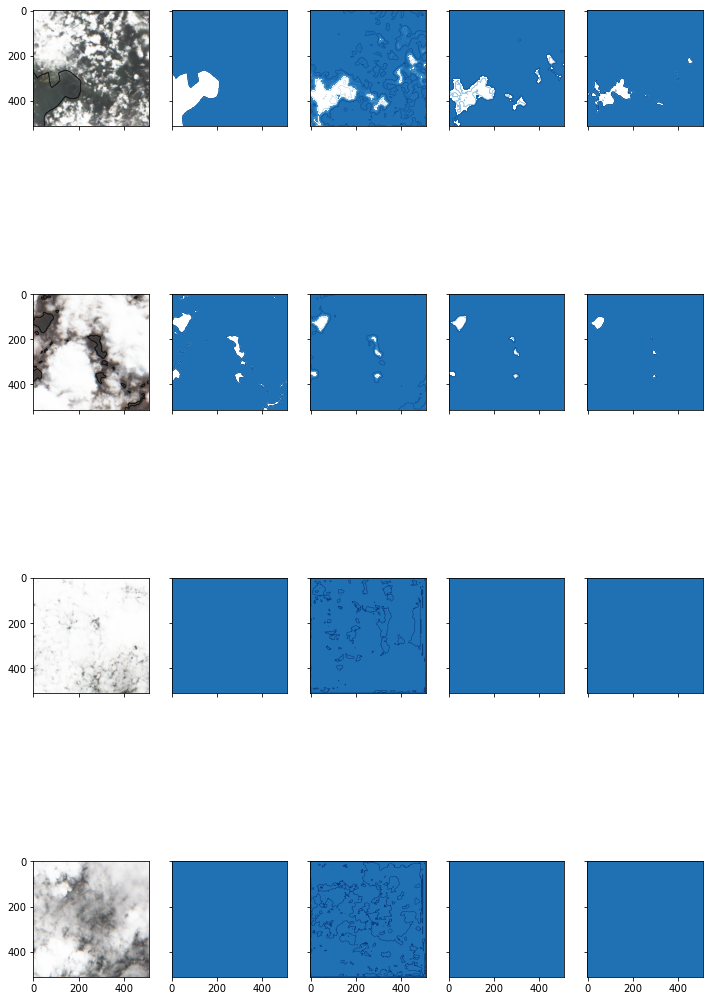

In [55]:
thresh=0.35
create_image_figure(images, labels, preds, *f(preds, low=thresh, high=.5, beta=150));

/tmp/ipykernel_2237/598965433.py:8: UserWarning: The probability range is outside [0, 1] given the tolerance `prob_tol`. Consider decreasing `beta` and/or decreasing `tol`.
  labels[i] = random_walker(preds[i], labels[i], **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/skimage/segmentation/random_walker_segmentation.py:470: UserWarning: Random walker only segments unlabeled areas, where labels == 0. No zero valued areas in labels were found. Returning provided labels.
  inds_isolated_seeds, isolated_values) = _preprocess(labels)


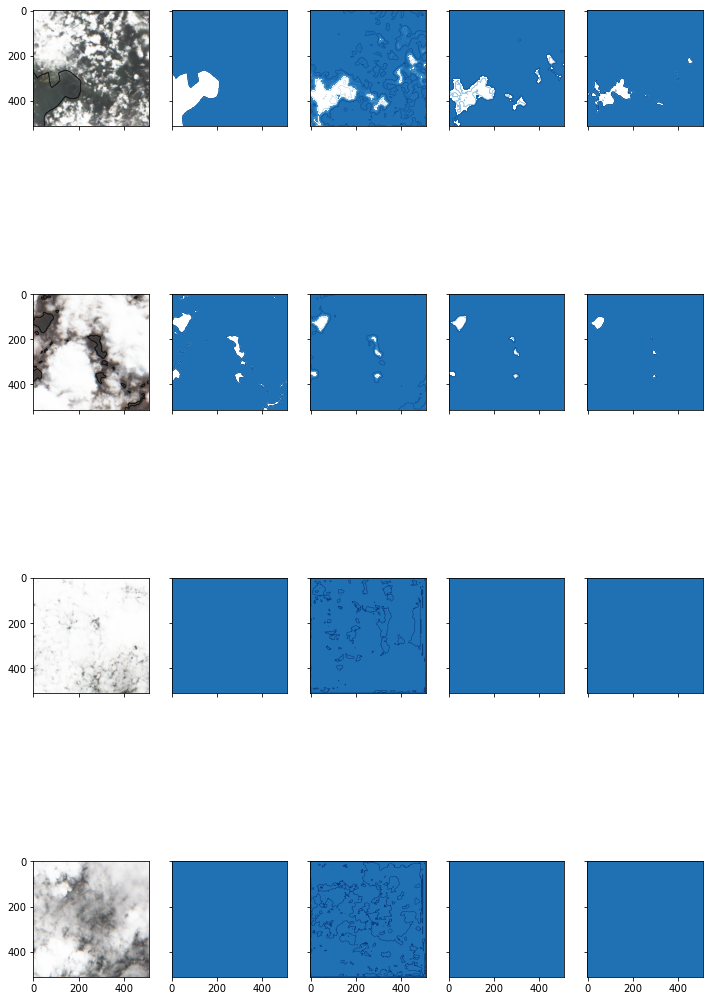

In [56]:
create_image_figure(images, labels, preds, *f(preds, low=thresh, high=.5, beta=0));

In [58]:
df = pd.read_csv("../scripts/rand_walk_threshold_stats_clean.csv")
df['IoU'] = df['TP']/df[['TP', 'FP', 'FN']].sum(axis=1)

<AxesSubplot:xlabel='Unnamed: 0'>

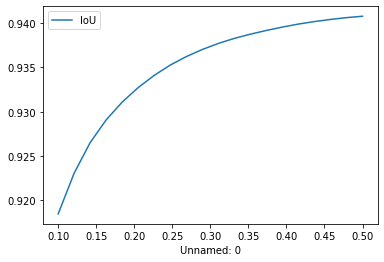

In [59]:
df.plot(y='IoU', x = 'Unnamed: 0')

<AxesSubplot:xlabel='Unnamed: 0'>

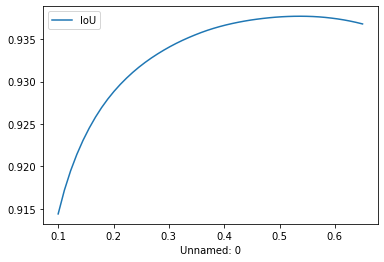

In [52]:
df = pd.read_csv("../scripts/threshold_stats_clean.csv")
df.plot(y='IoU', x = 'Unnamed: 0')